# Creating Master Files

In this notebook we are going to be writing code to create a master BIAS, master darks and master flats for the observations of RV UMa. Before we get started, here is a brief explanation of what these files are and why they have to be reduced and treated.

* What is a master dark/bias/flat image?

    A master image is a combination of several raw images, averaged per pixel to reduce the noise. They are what is used since noise is random, and as such can be averaged out of this kind of images, which on paper have to be always the same. They then allow us to remove all of these effects from the science image, getting to an image of what we wanted to observe with no effects of the telescope messing with it.

* What is a dark frame?

    A dark frame is an image taken with the shutter on the telescope, and is used to account for dark current, which can lead to false positives in the photon count. Ideally, they have the same exposure as the science frames, but they can be scaled to different exposures if the bias is removed first.

* What is a flat frame?

    A flat frame is an image of the entire sky, uniformly lit, used to account for stuff in the telescope (like dust) that can get in the way of the science image. They are taken with a white t-shirt draped over the unfocused lens.

* What is a bias frame?

    A bias is an offset voltage applied so that all the voltages in the image are positive and as such can be digitalized (a negative voltage cannot be possibly converted into a number). A bias frame is an image with the shutter closed and the shortest possible exposure that gives us the value of this bias. Ideally, it should be constant, but that is often not the case.

## Creating the master bias files

We start by averaging the bias files to create a master bias. First, the imports.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

plt.style.use('guide.mplstyle')

We create a new directory to store our reduced images.

In [2]:
calibrated_data = Path('..', 'bias-reduced')
calibrated_data.mkdir(exist_ok=True)

And this is the path to our raw bias images.

In [3]:
bias_files = Path('..', '2022_03_20', 'Bias') # = 22022_03_20/Bias
files = ccdp.ImageFileCollection(bias_files)

In [4]:
files.summary[:5]

file,simple,bitpix,naxis,naxis1,naxis2,extend,bzero,bscale,roworder,instrume,telescop,observer,object,exptime,ccd-temp,pixsize1,pixsize2,xbinning,ybinning,xpixsz,ypixsz,frame,imagetyp,filter,focallen,aptdia,scale,date-obs,gain,offset,comment
str27,bool,int32,int32,int32,int32,bool,int32,int32,str8,str21,str7,str7,str7,float64,float64,float64,float64,int32,int32,float64,float64,str4,str10,str3,float64,float64,float64,str23,float64,float64,str162
Bias_0.000032_secs_001.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:40:46.934,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_002.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:40:55.842,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_003.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:01.705,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_004.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:08.115,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"
Bias_0.000032_secs_005.fits,True,16,2,4656,3520,True,32768,1,TOP-DOWN,ZWO CCD ASI1600MM Pro,SynScan,Unknown,Unknown,3.2e-05,-5.0,3.8,3.8,1,1,3.8,3.8,Bias,Bias Frame,SII,1600.0,200.0,0.4899625,2022-03-21T15:41:14.401,139.0,10.0,"FITS (Flexible Image Transport System) format is defined in 'Astronomy, and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H,Generated by INDI"


### Combining BIAS images to make a master

We are using ccdproc to combine the images into a master. We are using the average to do so, but clipping according to the median to prevent outliers from skewing the image too much. If the file already exists it is pointless to run the code, so it has a check to prevent it from running if that is the case.

In [5]:
path_to_combined_bias = Path(calibrated_data, 'combined_bias.fit')
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)
if path_to_combined_bias.is_file():
    print('File exists,no combination necessary')
    combined_bias = path_to_combined_bias
else:
    combined_bias = ccdp.combine(calibrated_biases,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6, unit = 'adu'
                                 )

    combined_bias.meta['combined'] = True
    combined_bias.write(calibrated_data / 'combined_bias.fit', overwrite = False)

File exists,no combination necessary


### Showing the difference between a raw bias and the master

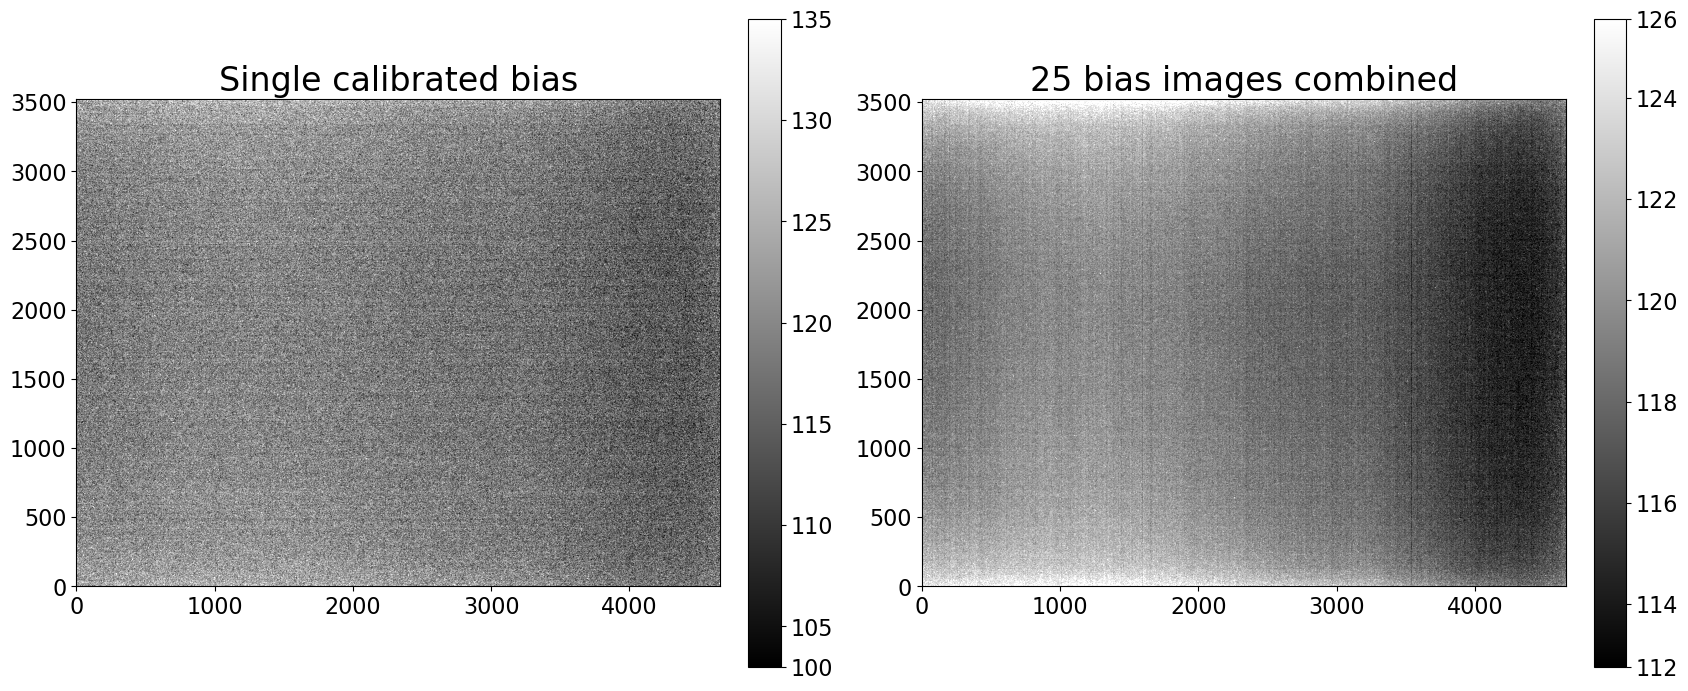

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_biases[0], unit = 'adu').data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated bias')
show_image(CCDData.read(combined_bias), cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} bias images combined'.format(len(calibrated_biases)));

## Combining darks by exposure time
Since we have darks for the different exposure times we don't need to subtract the BIAS in the files, and no calibration is necessary.

In [7]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [8]:
calibrated_darks_path = Path('..', 'darks-reduced')
calibrated_darks_path.mkdir(exist_ok=True)

In [9]:
dark_files_path = Path('..', '2022_03_20', 'Dark')
dark_files = ccdp.ImageFileCollection(dark_files_path)

In [10]:
darks = dark_files.summary['imagetyp'] == 'Dark Frame'
dark_times = set(dark_files.summary['exptime'][darks])
print(dark_times)

{32.0, 0.01, 0.0032, 16.0, 0.02}


In [11]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [12]:
for exp_time in sorted(dark_times):
    path_dark_file = Path(calibrated_darks_path, f'combined_dark_{exp_time}.fit')
    if path_dark_file.is_file():
        print(f'Master dark for {exp_time} already exists')
    else:
        calibrated_darks = dark_files.files_filtered(imagetyp='Dark Frame', exptime=exp_time,
                                                         include_path=True)

        combined_dark = ccdp.combine(calibrated_darks,
                                     method='average',
                                     sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                     sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                     mem_limit=350e6, unit = 'adu', verbose = False
                                     )

        combined_dark.meta['combined'] = True

        dark_file_name = f'combined_dark_{exp_time}.fit'
        combined_dark.write(calibrated_darks_path / dark_file_name)


Master dark for 0.0032 already exists
Master dark for 0.01 already exists
Master dark for 0.02 already exists
Master dark for 16.0 already exists
Master dark for 32.0 already exists


NameError: name 'calibrated_darks' is not defined

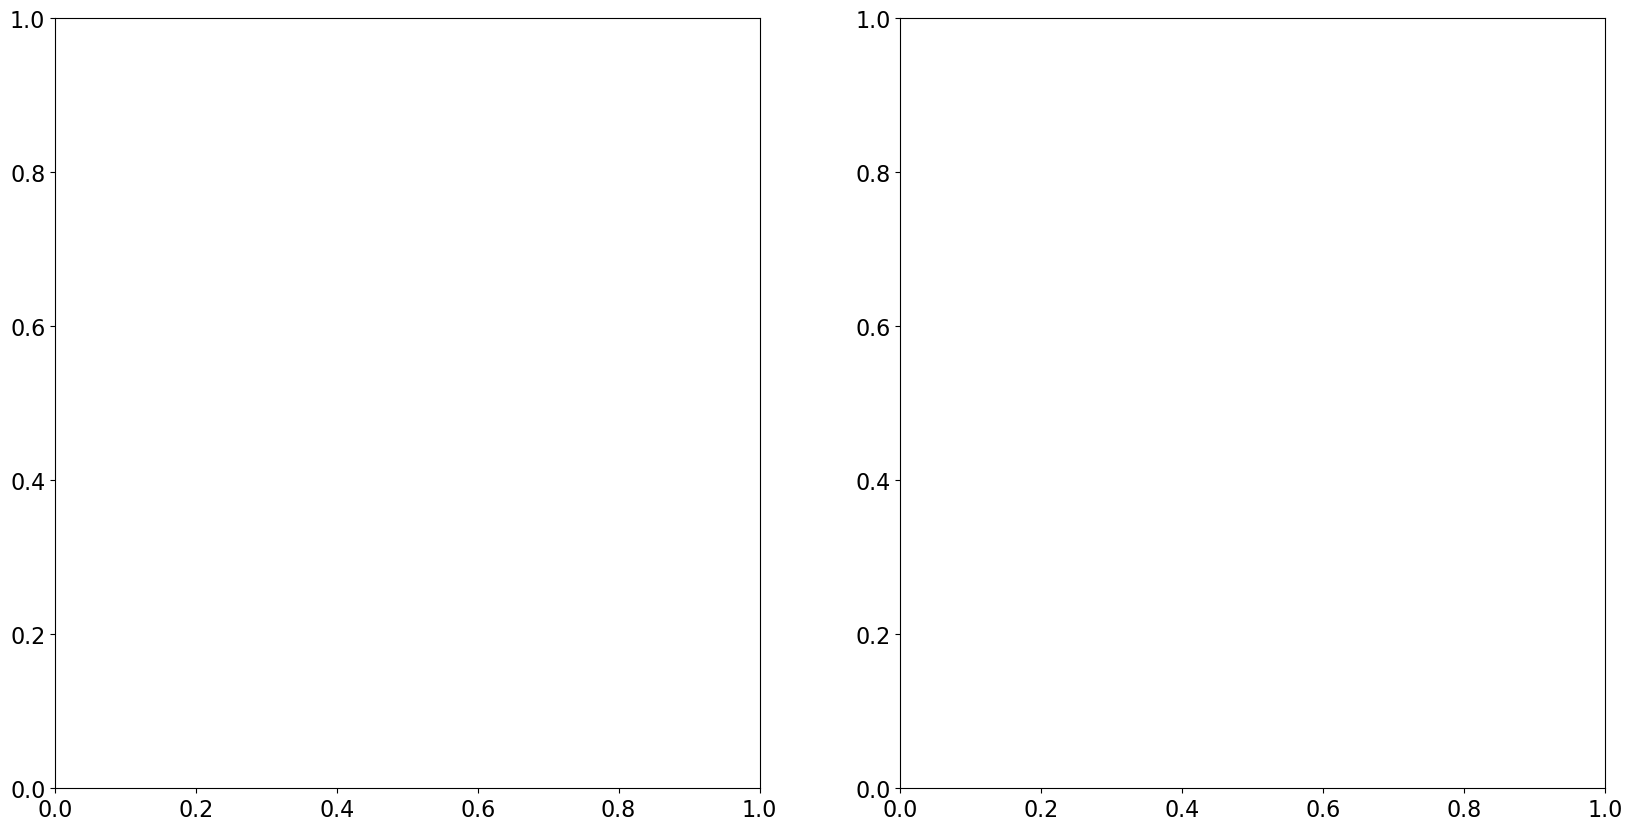

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0], unit = 'adu').data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))

# Combined Flats

In [14]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.

    Parameters
    ----------

    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.

    dark_exposure_times : list
        Exposure times for which there are darks.

    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.

    Returns
    -------

    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and
            np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):

        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, image.header['exptime']))


    return closest_dark_exposure

In [15]:
from pathlib import Path

from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from matplotlib import pyplot as plt
import numpy as np

from convenience_functions import show_image

In [16]:
filter_name = 'Blue'

reduced_path = Path('..', 'darks-reduced')
destination_path = Path('..', 'reduced-flats', filter_name)
destination_path.mkdir( exist_ok = True)

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='Dark Frame', combined=True)

flat_image_type = 'FLATFIELD'

In [17]:
raw_data = Path('..', '2022_03_20', 'Flat', filter_name)

ifc_raw = ccdp.ImageFileCollection(raw_data)

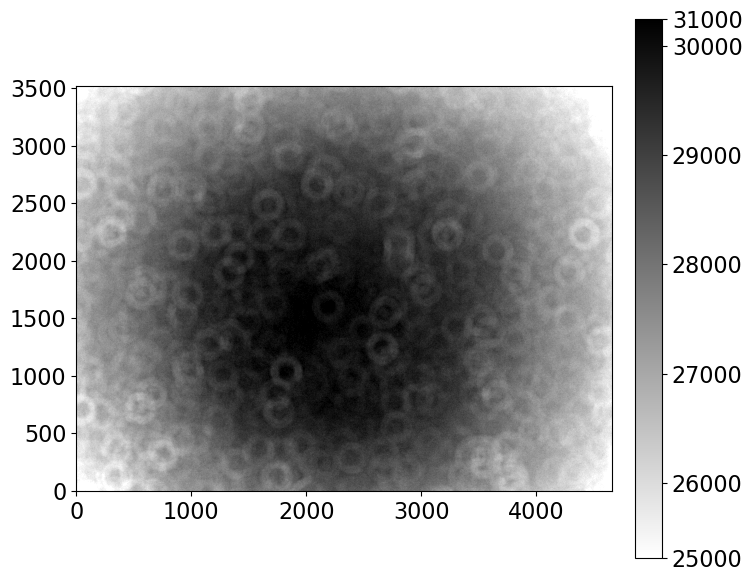

In [18]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='Flat Frame', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray_r')

plt.savefig('./Images/normal_flat.png')

In [23]:
a_flat.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4656 / length of data axis 1                          
NAXIS2  =                 3520 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '        

In [19]:
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='Dark Frame', combined=True))

In [20]:
closest_dark = find_nearest_dark_exposure(a_flat, actual_exposure_times)

In [21]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='Dark Frame', combined=True)}

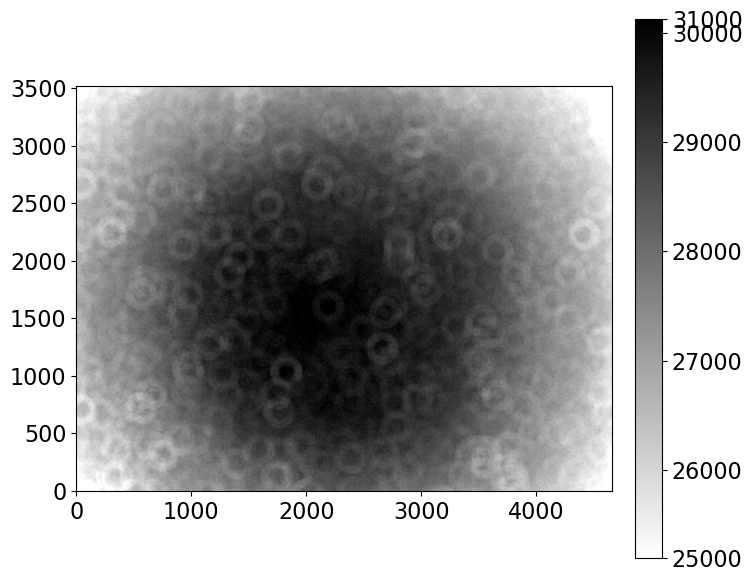

In [22]:
a_flat_reduced = ccdp.subtract_dark(a_flat, combined_darks[closest_dark],
                                    exposure_time='exptime', exposure_unit=u.second, scale=False)
show_image(a_flat_reduced, cmap='gray_r')

plt.savefig('./Images/reduced-flat.png')

In [ ]:
for ccd, file_name in ifc_raw.ccds(imagetyp='Flat Frame',  # Just get the flat frames
                                   ccd_kwargs={'unit': 'adu'},  # CCDData requires a unit for the image if
                                   # it is not in the header
                                   return_fname=True  # Provide the file name too.
                                   ):
    path_flat_file = Path('..', 'reduced-flats', 'flat-'+file_name)
    if path_flat_file.is_file():
        print('File already exists')
    else:
        # Find the correct dark exposure
        closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times)

        # Subtract the dark current
        ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                                 exposure_time='exptime', exposure_unit=u.second)

        # Save the result; there are some duplicate file names so pre-pend "flat"
        ccd.write(destination_path / ('flat-' + file_name))

# Combining Flats

In [ ]:
calibrated_flat_path = Path('..', 'reduced-flats', filter_name)

flat_imagetyp = 'Flat Frame'

ifc = ccdp.ImageFileCollection(calibrated_flat_path)

In [ ]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

In [ ]:
def inv_median(a):
    return 1 / np.median(a)

In [ ]:
for filt in flat_filters:
    path_flat_file = Path(calibrated_flat_path, 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p")))
    if path_flat_file.is_file():
        print(f'Master flat for filter {filt} already exists')
    else:
        to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
        combined_flat = ccdp.combine(to_combine,
                                     method='average', scale=inv_median,
                                     sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                     sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                     mem_limit=350e6
                                     )

        combined_flat.meta['combined'] = True
        flat_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
        combined_flat.write(calibrated_flat_path / flat_file_name)

In [ ]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

In [ ]:
show_image(combined_flat, cmap = 'gray')